In [ ]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from postprocessing import consistency as cons

# Setup

In [ ]:
VALID_RESPONSES_PATH = '../../results/valid_responses'
PLOTS_PATH = '../../results/plots'

In [4]:
vis.sns_reset()
vis.sns_paper_style()

## Data

In [5]:
df_valid_responses = io.pd.concat([io.read_csv(io.path_join(VALID_RESPONSES_PATH, f"{model}.csv"), index_col=0) for model in constants.LLMS], ignore_index=True)
df_valid_responses['task_name'] = io.pd.Categorical(df_valid_responses['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_valid_responses.shape


(138439, 14)

In [6]:
df_valid_responses.head(2)

,date,time,llm_model,task_name,task_param,task_attempt,result_valid_flag,name,years,doi,career_age,clean_name,model,valid_attempt
0,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Richard Feynman,1950-1960,NaN,NaN,richard feynman,llama3-8b,True
1,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Julian Schwinger,1950-1960,NaN,NaN,julian schwinger,llama3-8b,True


# Consistency
Similarity of results

In [7]:
df_consistency = cons.run_consistency_jaccard_similarity(df_valid_responses)
df_consistency['task_name'] = io.pd.Categorical(df_consistency['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_consistency_task = df_consistency.groupby(['model','task_name']).jaccard_similarity_mean.agg(['mean','std']).reset_index()
df_consistency_task.fillna({'std':0}, inplace=True)

Processing Groups:   9%|▉         | 8/87 [00:00<00:01, 78.76it/s]/Users/espinl/anaconda3/envs/py311LLMEval/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/espinl/anaconda3/envs/py311LLMEval/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/espinl/anaconda3/envs/py311LLMEval/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/espinl/anaconda3/envs/py311LLMEval/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/espinl/anaconda3/envs/py311LLMEval/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encoun

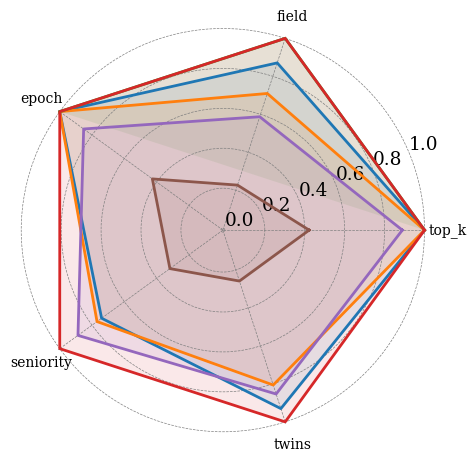

In [8]:
fname = 'consistency_jaccard.pdf'
fn = io.path_join(PLOTS_PATH, fname)

hue = 'model'
x_col = 'task_name'
x_order = constants.EXPERIMENT_TASKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_consistency_task, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, 
                   fn=fn,
                   legend_kwargs = constants.PLOT_LEGEND_KWARGS_SPIDER,
                   figsize=constants.PLOT_FIGSIZE_SPIDER)

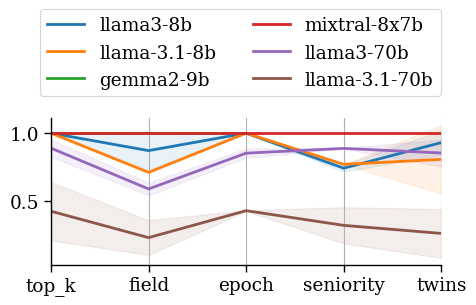

In [9]:
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

df_consistency_mean_t = helpers.pivot_model_tasks(df_consistency_task, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_consistency_std_t = helpers.pivot_model_tasks(df_consistency_task, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_consistency_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_consistency_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE, # paper
                        #  figsize=(5, 3), # slides
                         fn=fn)

## Latex

In [10]:
df = df_consistency.copy()

# Combine mean and std into a single column
df['mean_std'] = df.apply(
    lambda x: f"{x['jaccard_similarity_mean']:.2f} ({x['jaccard_similarity_std']:.2f})", axis=1
)

# Pivot table with (task_name, task_param) as index
pivot_df = df.pivot(index=['task_name', 'task_param'], columns='model', values='mean_std')

# Reindex rows and columns to desired order
pivot_df = pivot_df.reindex(columns=constants.LLMS)

# Fill missing entries with '-'
pivot_df = pivot_df.fillna('-').reset_index()

# summary columns
pivot_df = helpers.add_mean_values_rows_columns_of_pivot(pivot_df)

# Convert to LaTeX
latex_code = pivot_df.drop(columns=['task_name']).to_latex(index=False, escape=True)

print(latex_code)


\begin{tabular}{llllllll}
\toprule
task\_param & llama3-8b & llama-3.1-8b & gemma2-9b & mixtral-8x7b & llama3-70b & llama-3.1-70b & Row Mean \\
\midrule
top\_100 & - & 1.00 (0.00) & - & 1.00 (0.00) & 0.84 (0.31) & 0.27 (0.11) & 0.78 \\
top\_5 & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 0.93 (0.13) & 0.57 (0.26) & 0.92 \\
CM\&MP & 0.77 (0.26) & - & - & 1.00 (0.00) & 0.55 (0.20) & 0.14 (0.17) & 0.62 \\
PER & 0.97 (0.11) & 0.71 (0.26) & 1.00 (0.00) & 1.00 (0.00) & 0.62 (0.46) & 0.32 (0.22) & 0.77 \\
1950s & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 0.88 (0.22) & 0.43 (0.27) & 0.88 \\
2000s & - & - & - & 1.00 (0.00) & 0.83 (0.34) & 0.42 (0.26) & 0.75 \\
early\_career & 0.76 (0.39) & 0.77 (0.23) & - & 1.00 (0.00) & 0.89 (0.24) & 0.22 (0.26) & 0.73 \\
senior & 0.72 (0.28) & - & - & 1.00 (0.00) & 0.89 (0.27) & 0.41 (0.30) & 0.76 \\
famous\_female & 1.00 (0.00) & nan (nan) & - & 1.00 (0.00) & 0.75 (0.41) & 0.38 (0.38) & 0.78 \\
famous\_male & 0.87 (0.15) & 0.94 (0.0

# Uniqueness

In [11]:
df_uniqueness = cons.run_consistency_uniqueness(df_valid_responses)
df_uniqueness['task_name'] = io.pd.Categorical(df_uniqueness['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_uniqueness_task = df_uniqueness.groupby(['model','task_name'], observed=False).uniqueness_pct.agg(['mean','std']).reset_index()
df_uniqueness_task.head(2)

,model,task_name,mean,std
0,gemma2-9b,top_k,1.0,0.0
1,gemma2-9b,field,1.0,0.0


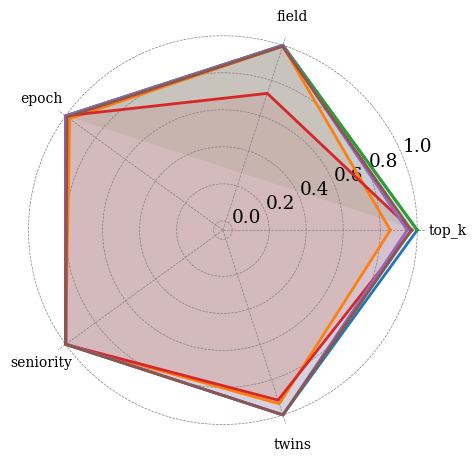

In [12]:
fname = 'consistency_uniqueness.pdf'
fn = io.path_join(PLOTS_PATH, fname)

hue = 'model'
x_col = 'task_name'
x_order = constants.EXPERIMENT_TASKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_uniqueness_task, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ytickval=0.5,
                   fn=fn,
                   legend_kwargs = {'title':'', 'loc': 'lower left', 'ncols':2, 'bbox_to_anchor':(-0.04,1.02,1,0.2)},
                   figsize=constants.PLOT_FIGSIZE_SPIDER)

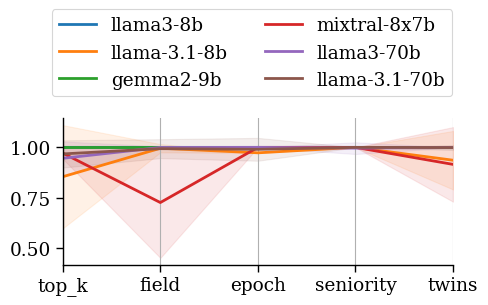

In [13]:
from matplotlib.pyplot import ylim


fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

df_uniqueness_mean_t = helpers.pivot_model_tasks(df_uniqueness_task, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_uniqueness_std_t = helpers.pivot_model_tasks(df_uniqueness_task, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_uniqueness_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_uniqueness_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE, # paper
                        #  figsize=(5, 3), # slides
                        #  ylim=(-0.1,1.1), # slides
                         fn=fn)

## Latex

In [14]:
df_uniqueness.head()

,model,task_name,task_param,date,time,unique_names,total_names,duplicates,duplicates_pct,uniqueness,uniqueness_pct
0,gemma2-9b,top_k,top_5,2024-12-09,00:00,5,5,0,0.0,5,1.0
1,gemma2-9b,top_k,top_5,2024-12-09,08:00,5,5,0,0.0,5,1.0
2,gemma2-9b,top_k,top_5,2024-12-09,16:00,5,5,0,0.0,5,1.0
3,gemma2-9b,top_k,top_5,2024-12-10,00:00,5,5,0,0.0,5,1.0
4,gemma2-9b,top_k,top_5,2024-12-10,08:00,5,5,0,0.0,5,1.0


In [15]:
df = df_uniqueness.groupby(['model','task_name','task_param'], observed=True).uniqueness_pct.agg(['mean','std']).reset_index()

# Combine mean and std into a single column
df['mean_std'] = df.apply(
    lambda x: f"{x['mean']:.2f} ({x['std']:.2f})", axis=1
)

# Pivot table with (task_name, task_param) as index
pivot_df = df.pivot(index=['task_name', 'task_param'], columns='model', values='mean_std')


# Reindex rows and columns to desired order
pivot_df = pivot_df.reindex(columns=constants.LLMS)

# Fill missing entries with '-'
pivot_df = pivot_df.fillna('-').reset_index()

# summary columns
pivot_df = helpers.add_mean_values_rows_columns_of_pivot(pivot_df)


# Convert to LaTeX
latex_code = pivot_df.drop(columns=['task_name']).to_latex(index=False, escape=True)

print(latex_code)


\begin{tabular}{llllllll}
\toprule
task\_param & llama3-8b & llama-3.1-8b & gemma2-9b & mixtral-8x7b & llama3-70b & llama-3.1-70b & Row Mean \\
\midrule
top\_100 & - & 0.41 (0.00) & - & 0.94 (0.00) & 0.89 (0.09) & 0.94 (0.08) & 0.79 \\
top\_5 & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 1.00 \\
CM\&MP & 1.00 (0.00) & - & - & 1.00 (0.00) & 1.00 (0.01) & 0.99 (0.07) & 1.00 \\
PER & 1.00 (0.00) & 1.00 (0.02) & 1.00 (0.00) & 0.45 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 0.91 \\
1950s & 1.00 (0.00) & 0.97 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 0.99 \\
2000s & - & - & - & 1.00 (0.00) & 1.00 (0.00) & 0.98 (0.08) & 0.99 \\
early\_career & 1.00 (0.00) & 1.00 (0.00) & - & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 1.00 \\
senior & 1.00 (0.00) & - & - & 1.00 (0.00) & 0.99 (0.04) & 1.00 (0.00) & 1.00 \\
famous\_female & 1.00 (0.00) & 1.00 (nan) & - & 1.00 (0.00) & 1.00 (0.00) & 1.00 (0.00) & 1.00 \\
famous\_male & 1.00 (0.00) & 1.00 (0.